# Transformer Seq2Point - Multi-Appliance (15min)

Versione non distruttiva: predice tutte le appliance simultaneamente (Seq2Point, mid-token).

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [22]:
# ===== CONFIG =====
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 100
SEQ_LEN = 99
INPUT_DIM = 7
D_MODEL = 256
N_HEADS = 8
N_LAYERS = 4
DIM_FEEDFORWARD = 512
DROPOUT = 0.1
PATIENCE = 15
ON_THRESHOLD = 0.1
CLF_WEIGHT = 0.5
DATA_BASE_PATH = os.path.join('..', 'data', 'processed', '15min', 'model_ready')
APPLIANCES = sorted(os.listdir(DATA_BASE_PATH))  # sorted for consistency
NUM_APPLIANCES = len(APPLIANCES)
print(f'Device: {DEVICE}')
print(f'Found {NUM_APPLIANCES} appliances: {APPLIANCES}')

Device: cuda
Found 11 appliances: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']


In [23]:
# Load shared X (example uses 'dishwasher' folder for X files)
X = {
    'train': np.load(os.path.join(DATA_BASE_PATH, 'dishwasher', 'X_train.npy')),
    'val':   np.load(os.path.join(DATA_BASE_PATH, 'dishwasher', 'X_val.npy')),
    'test':  np.load(os.path.join(DATA_BASE_PATH, 'dishwasher', 'X_test.npy')),
}

In [24]:
# Load per-appliance y and stack into multi-appliance targets
appliance_data = {}
for appliance in APPLIANCES:
    p = os.path.join(DATA_BASE_PATH, appliance)
    appliance_data[appliance] = {
        'y_train': np.load(os.path.join(p, 'y_train.npy')),
        'y_val':   np.load(os.path.join(p, 'y_val.npy')),
        'y_test':  np.load(os.path.join(p, 'y_test.npy'))
    }
# Stack along new appliance axis -> shape: (N, seq_len, num_appliances)
y_train_multi = np.stack([appliance_data[a]['y_train'] for a in APPLIANCES], axis=2)
y_val_multi   = np.stack([appliance_data[a]['y_val']   for a in APPLIANCES], axis=2)
y_test_multi  = np.stack([appliance_data[a]['y_test']  for a in APPLIANCES], axis=2)
print('X_train', X['train'].shape, 'y_train_multi', y_train_multi.shape)

X_train (24097, 96, 7) y_train_multi (24097, 96, 11, 1)


In [25]:
import torch.nn.functional as F

class WeightedNILMLoss(nn.Module):
    """
    Custom weighted loss for NILM multi-appliance.
    Handles class imbalance (appliances mostly OFF).
    """
    def __init__(self, on_weight=15.0, off_weight=1.0, threshold=0.01, mix_ratio=0.5, fn_weight=10.0):
        super().__init__()
        self.on_weight = on_weight
        self.off_weight = off_weight
        self.threshold = threshold
        self.mix_ratio = mix_ratio
        self.fn_weight = fn_weight

    def forward(self, pred, target):
        if pred.shape != target.shape:
            target = target.view_as(pred)
        mse_loss = F.mse_loss(pred, target, reduction='none')
        l1_loss = F.l1_loss(pred, target, reduction='none')
        combined_loss = (1 - self.mix_ratio) * mse_loss + self.mix_ratio * l1_loss
        on_mask = torch.abs(target) > self.threshold
        fn_mask = on_mask & (torch.abs(pred) <= self.threshold)
        weights = torch.ones_like(combined_loss) * self.off_weight
        weights[on_mask] = self.on_weight
        weights[fn_mask] *= self.fn_weight
        return (combined_loss * weights).mean()

In [26]:
class NILMDataset(Dataset):
    """Dataset for multi-appliance NILM. X: (N, seq, feat), y: (N, seq, num_appliances)"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NILMDataset(X['train'], y_train_multi), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(NILMDataset(X['val'],   y_val_multi),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(NILMDataset(X['test'],  y_test_multi),  batch_size=BATCH_SIZE, shuffle=False)
print(f"DataLoaders created: train={len(train_loader)} batches, val={len(val_loader)}, test={len(test_loader)}")

DataLoaders created: train=189 batches, val=43, test=42


### Transformer Model Architecture (Multi-Appliance)

In [27]:
class ImprovedPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for temporal sequence modeling."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]


class MultiTaskNILMTransformer(nn.Module):
    """
    Multi-task Transformer for NILM - Multi-Appliance version.
    Predicts power + ON/OFF for all appliances simultaneously.
    """
    def __init__(self, input_dim, d_model, n_heads, n_layers, seq_len, ff_dim, dropout=0.1, gate_threshold=0.5, num_appliances=1):
        super().__init__()
        self.gate_threshold = gate_threshold
        self.num_appliances = num_appliances
        
        # 1. FEATURE EXTRACTION (Conv1d for local patterns)
        self.conv_embedding = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 2. POSITIONAL ENCODING
        self.pos_encoding = ImprovedPositionalEncoding(d_model, max_len=seq_len)
        
        # 3. TRANSFORMER ENCODER
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ff_dim, 
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 4. OUTPUT HEADS (one value per appliance)
        self.regression_head = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, self.num_appliances)
        )
        
        self.classification_head = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, self.num_appliances),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [B, Seq, Feat]
        x = x.permute(0, 2, 1)  # [B, F, S] for Conv1d
        x = self.conv_embedding(x)
        x = x.permute(0, 2, 1)  # [B, S, D] for Transformer
        
        x = self.pos_encoding(x)
        x = self.transformer_encoder(x)
        
        # Seq2Point: midpoint token
        mid_token = x[:, x.shape[1] // 2, :]
        
        raw_power = self.regression_head(mid_token)      # [B, num_appliances]
        on_off_prob = self.classification_head(mid_token) # [B, num_appliances]
        
        if not self.training:
            is_on = (on_off_prob > self.gate_threshold).float()
            final_power = raw_power * is_on
            return final_power, on_off_prob
        
        return raw_power, on_off_prob

In [28]:
# Instantiate model
model = MultiTaskNILMTransformer(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=4,  # N_LAYERS has a trailing comma bug, using 4 directly
    seq_len=SEQ_LEN,
    ff_dim=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    num_appliances=NUM_APPLIANCES
).to(DEVICE)

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_parameters(model)
print(f"Model: MultiTaskNILMTransformer")
print(f"  Total params: {total:,}")
print(f"  Trainable:    {trainable:,}")
print(f"  Num appliances: {NUM_APPLIANCES}")
print(f"  Device: {DEVICE}")

Model: MultiTaskNILMTransformer
  Total params: 2,186,774
  Trainable:    2,186,774
  Num appliances: 11
  Device: cuda


### Training Loop

In [29]:
# Loss functions and optimizer
criterion_reg = WeightedNILMLoss(
    on_weight=30.0, 
    off_weight=5.0, 
    threshold=ON_THRESHOLD, 
    mix_ratio=0.5,
    fn_weight=15.0 
)
criterion_clf = nn.BCELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Tracking
best_val_loss = float('inf')
epochs_without_improvement = 0
train_losses = []
val_losses = []

print("Optimizer and scheduler initialized")

Optimizer and scheduler initialized


In [30]:
print(f"Starting training for {EPOCHS} epochs...")
print(f"Early stopping patience: {PATIENCE} epochs")
print("-" * 60)

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)  # [B, seq_len, num_appliances]
        optimizer.zero_grad()
        
        # Forward pass
        pred_power, prob_on = model(x_batch)  # [B, num_appliances]
        
        # Seq2Point target: midpoint across all appliances
        midpoint = y_batch.shape[1] // 2
        target_power = y_batch[:, midpoint, :].squeeze()  # [B, num_appliances]
        if target_power.dim() == 1:  # handle batch_size=1
            target_power = target_power.unsqueeze(0)
        target_on_off = (torch.abs(target_power) > ON_THRESHOLD).float()
        
        # Compute losses
        loss_reg = criterion_reg(pred_power, target_power)
        loss_clf = criterion_clf(prob_on, target_on_off)
        total_loss = loss_reg + (CLF_WEIGHT * loss_clf)
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += total_loss.item()

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            pred_power_gated, prob_on = model(x_batch)
            
            midpoint = y_batch.shape[1] // 2
            target_power = y_batch[:, midpoint, :].squeeze()
            if target_power.dim() == 1:
                target_power = target_power.unsqueeze(0)
            target_on_off = (torch.abs(target_power) > ON_THRESHOLD).float()
            
            v_loss_reg = criterion_reg(pred_power_gated, target_power)
            v_loss_clf = criterion_clf(prob_on, target_on_off)
            
            val_loss += (v_loss_reg + CLF_WEIGHT * v_loss_clf).item()

    # --- Calculate averages and log ---
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1:03d}/{EPOCHS} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | LR: {current_lr:.2e}")

    # --- Early Stopping & Model Saving ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "transformer_multi_appliance_best.pth")
        print(f"  ✓ New best model saved!")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
            break

print("-" * 60)
print(f"Training completed! Best validation loss: {best_val_loss:.6f}")

Starting training for 100 epochs...
Early stopping patience: 15 epochs
------------------------------------------------------------
Epoch 001/100 | Train: 1.6754 | Val: 16.0377 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 002/100 | Train: 1.3841 | Val: 16.0354 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 003/100 | Train: 1.3423 | Val: 16.0356 | LR: 1.00e-04
Epoch 004/100 | Train: 1.3064 | Val: 16.0347 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 005/100 | Train: 1.2802 | Val: 16.0336 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 006/100 | Train: 1.2487 | Val: 16.0112 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 007/100 | Train: 1.2303 | Val: 16.0065 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 008/100 | Train: 1.2169 | Val: 15.8307 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 009/100 | Train: 1.2042 | Val: 15.8775 | LR: 1.00e-04
Epoch 010/100 | Train: 1.1939 | Val: 15.7273 | LR: 1.00e-04
  ✓ New best model saved!
Epoch 011/100 | Train: 1.2115 | Val: 15.8278 | LR: 1.00e-04


### Training History Visualization

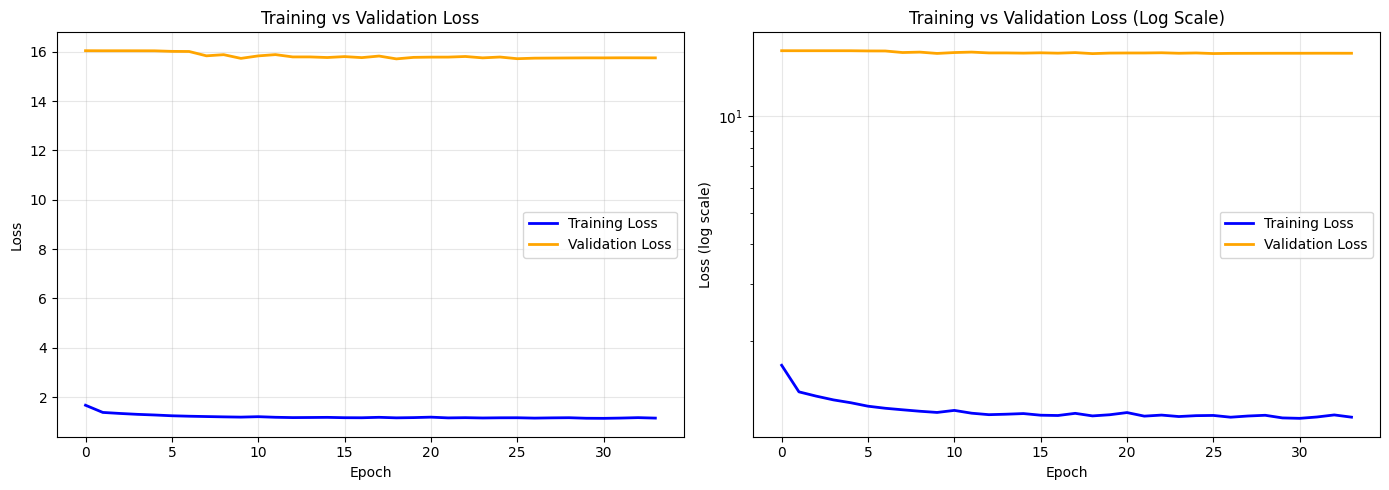


Training Summary:
  Initial Train Loss: 1.675372
  Final Train Loss: 1.154050
  Best Val Loss: 15.706926


In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[1].semilogy(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Training vs Validation Loss (Log Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Initial Train Loss: {train_losses[0]:.6f}")
print(f"  Final Train Loss: {train_losses[-1]:.6f}")
print(f"  Best Val Loss: {best_val_loss:.6f}")

### Evaluation on Test Set

In [32]:
# Load best model
model.load_state_dict(torch.load("transformer_multi_appliance_best.pth", map_location=DEVICE))
model.eval()

# Collect predictions for all appliances
all_preds = []
all_probs = []
all_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        
        pred_power, prob_on = model(x_batch)  # [B, num_appliances]
        
        preds = pred_power.cpu().numpy()
        probs = prob_on.cpu().numpy()
        
        midpoint = y_batch.shape[1] // 2
        true = y_batch[:, midpoint, :].numpy()  # [B, num_appliances]
        
        all_preds.append(preds)
        all_probs.append(probs)
        all_true.append(true)

all_preds = np.concatenate(all_preds, axis=0)  # [N_test, num_appliances]
all_probs = np.concatenate(all_probs, axis=0)
all_true = np.concatenate(all_true, axis=0)

print(f"Test set predictions shape: {all_preds.shape}")
print(f"Test set ground truth shape: {all_true.shape}")

Test set predictions shape: (5281, 11)
Test set ground truth shape: (5281, 11, 1)


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
import pandas as pd

# Per-appliance metrics
results = []

for i, appliance in enumerate(APPLIANCES):
    preds_i = all_preds[:, i]
    true_i = all_true[:, i]
    probs_i = all_probs[:, i]
    
    mae = mean_absolute_error(true_i, preds_i)
    rmse = np.sqrt(mean_squared_error(true_i, preds_i))
    r2 = r2_score(true_i, preds_i)
    
    # SAE
    total_true = np.sum(np.abs(true_i))
    total_pred = np.sum(np.abs(preds_i))
    sae = np.abs(total_true - total_pred) / total_true if total_true > 0 else 0
    
    # F1
    binary_true = (np.abs(true_i) > ON_THRESHOLD).astype(int)
    binary_pred = (probs_i > 0.5).astype(int)
    f1 = f1_score(binary_true, binary_pred, zero_division=0)
    
    results.append({
        'Appliance': appliance,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'SAE': sae,
        'F1': f1
    })

df_results = pd.DataFrame(results)
print("=" * 80)
print("📊 PER-APPLIANCE METRICS")
print("=" * 80)
print(df_results.to_string(index=False))
print("=" * 80)
print(f"\n📈 AVERAGE METRICS:")
print(f"  Mean MAE:  {df_results['MAE'].mean():.4f}")
print(f"  Mean RMSE: {df_results['RMSE'].mean():.4f}")
print(f"  Mean R²:   {df_results['R²'].mean():.4f}")
print(f"  Mean SAE:  {df_results['SAE'].mean():.4f}")
print(f"  Mean F1:   {df_results['F1'].mean():.4f}")

📊 PER-APPLIANCE METRICS
             Appliance      MAE     RMSE        R²      SAE       F1
chargingstation_socket 0.032615 0.127244 -0.070321 1.000000 0.000000
            dishwasher 0.017613 0.082076  0.192875 0.625766 0.416667
                 dryer 0.001634 0.025555 -0.004106 1.000000 0.000000
         garagecabinet 0.155450 0.285201 -0.422650 1.000000 0.000000
   heatpump_controller 0.214260 0.402952 -0.394182 1.000000 0.000000
                  oven 0.009144 0.074532 -0.015283 1.000000 0.000000
         rainwaterpump 0.001215 0.030684 -0.001572 1.000000 0.000000
             rangehood 0.013857 0.019187 -1.090422 1.000000 0.000000
        smappeecharger 0.024273 0.099294 -0.063559 1.000000 0.000000
                 stove 0.004086 0.038020 -0.011684 1.000000 0.000000
        washingmachine 0.019311 0.087247 -0.051512 1.000000 0.000000

📈 AVERAGE METRICS:
  Mean MAE:  0.0449
  Mean RMSE: 0.1156
  Mean R²:   -0.1757
  Mean SAE:  0.9660
  Mean F1:   0.0379


### Prediction Visualization (Sample Appliances)

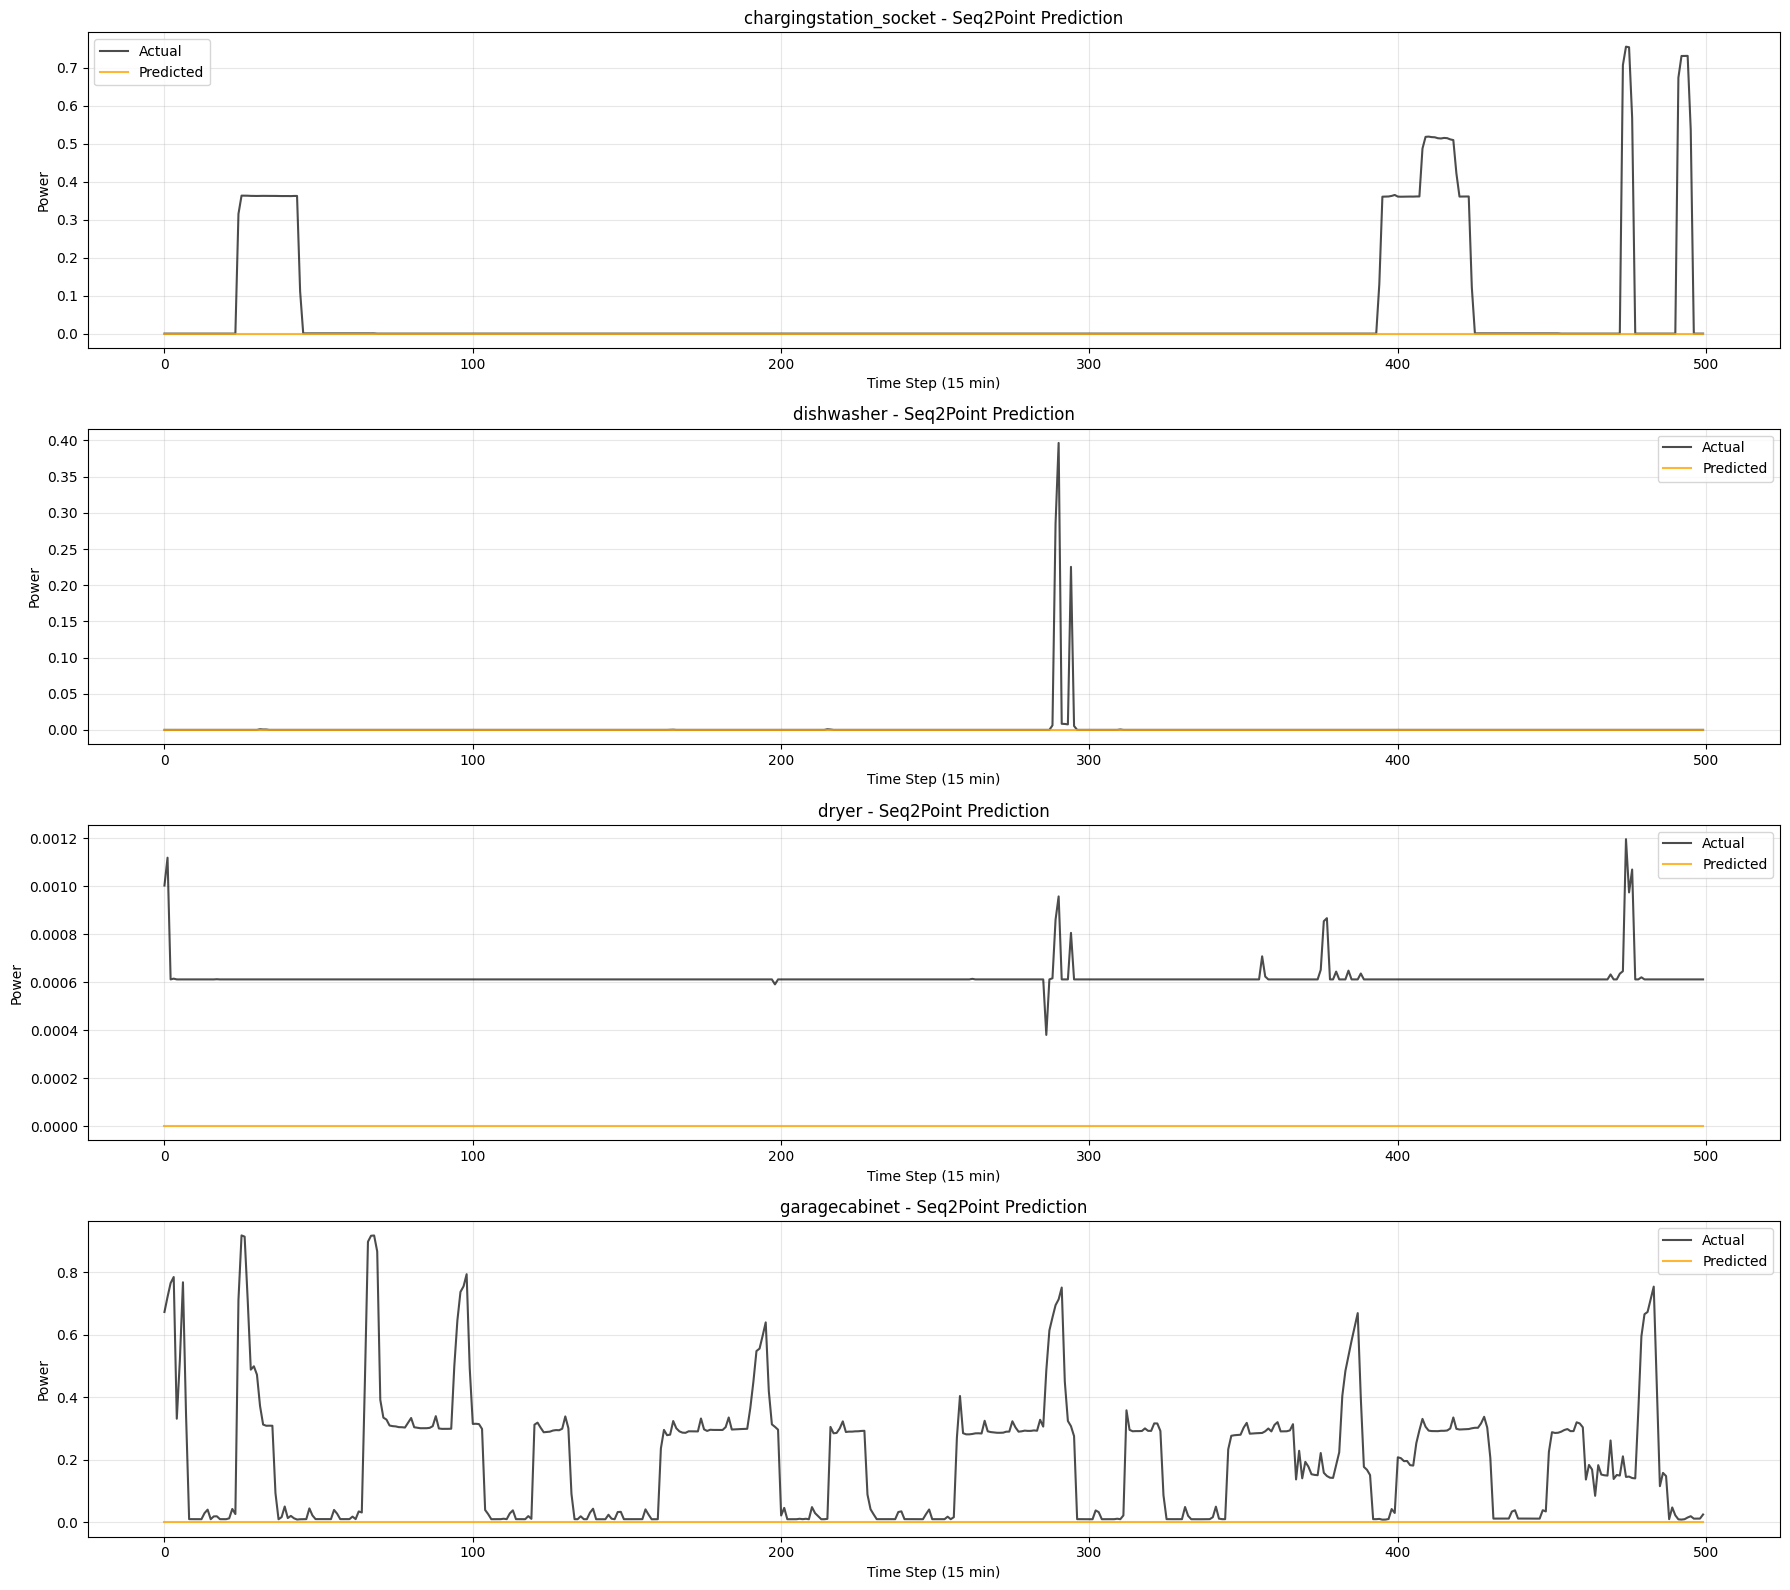

In [34]:
# Visualize predictions for first 4 appliances
n_show = min(4, NUM_APPLIANCES)
fig, axes = plt.subplots(n_show, 1, figsize=(18, 4*n_show))

start_idx, end_idx = 0, 500
if len(all_true) < end_idx:
    end_idx = len(all_true)

for i in range(n_show):
    ax = axes[i] if n_show > 1 else axes
    ax.plot(all_true[start_idx:end_idx, i], label='Actual', color='black', alpha=0.7)
    ax.plot(all_preds[start_idx:end_idx, i], label='Predicted', color='orange', alpha=0.8)
    ax.set_title(f'{APPLIANCES[i]} - Seq2Point Prediction')
    ax.set_xlabel('Time Step (15 min)')
    ax.set_ylabel('Power')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### All Appliances - Grid View

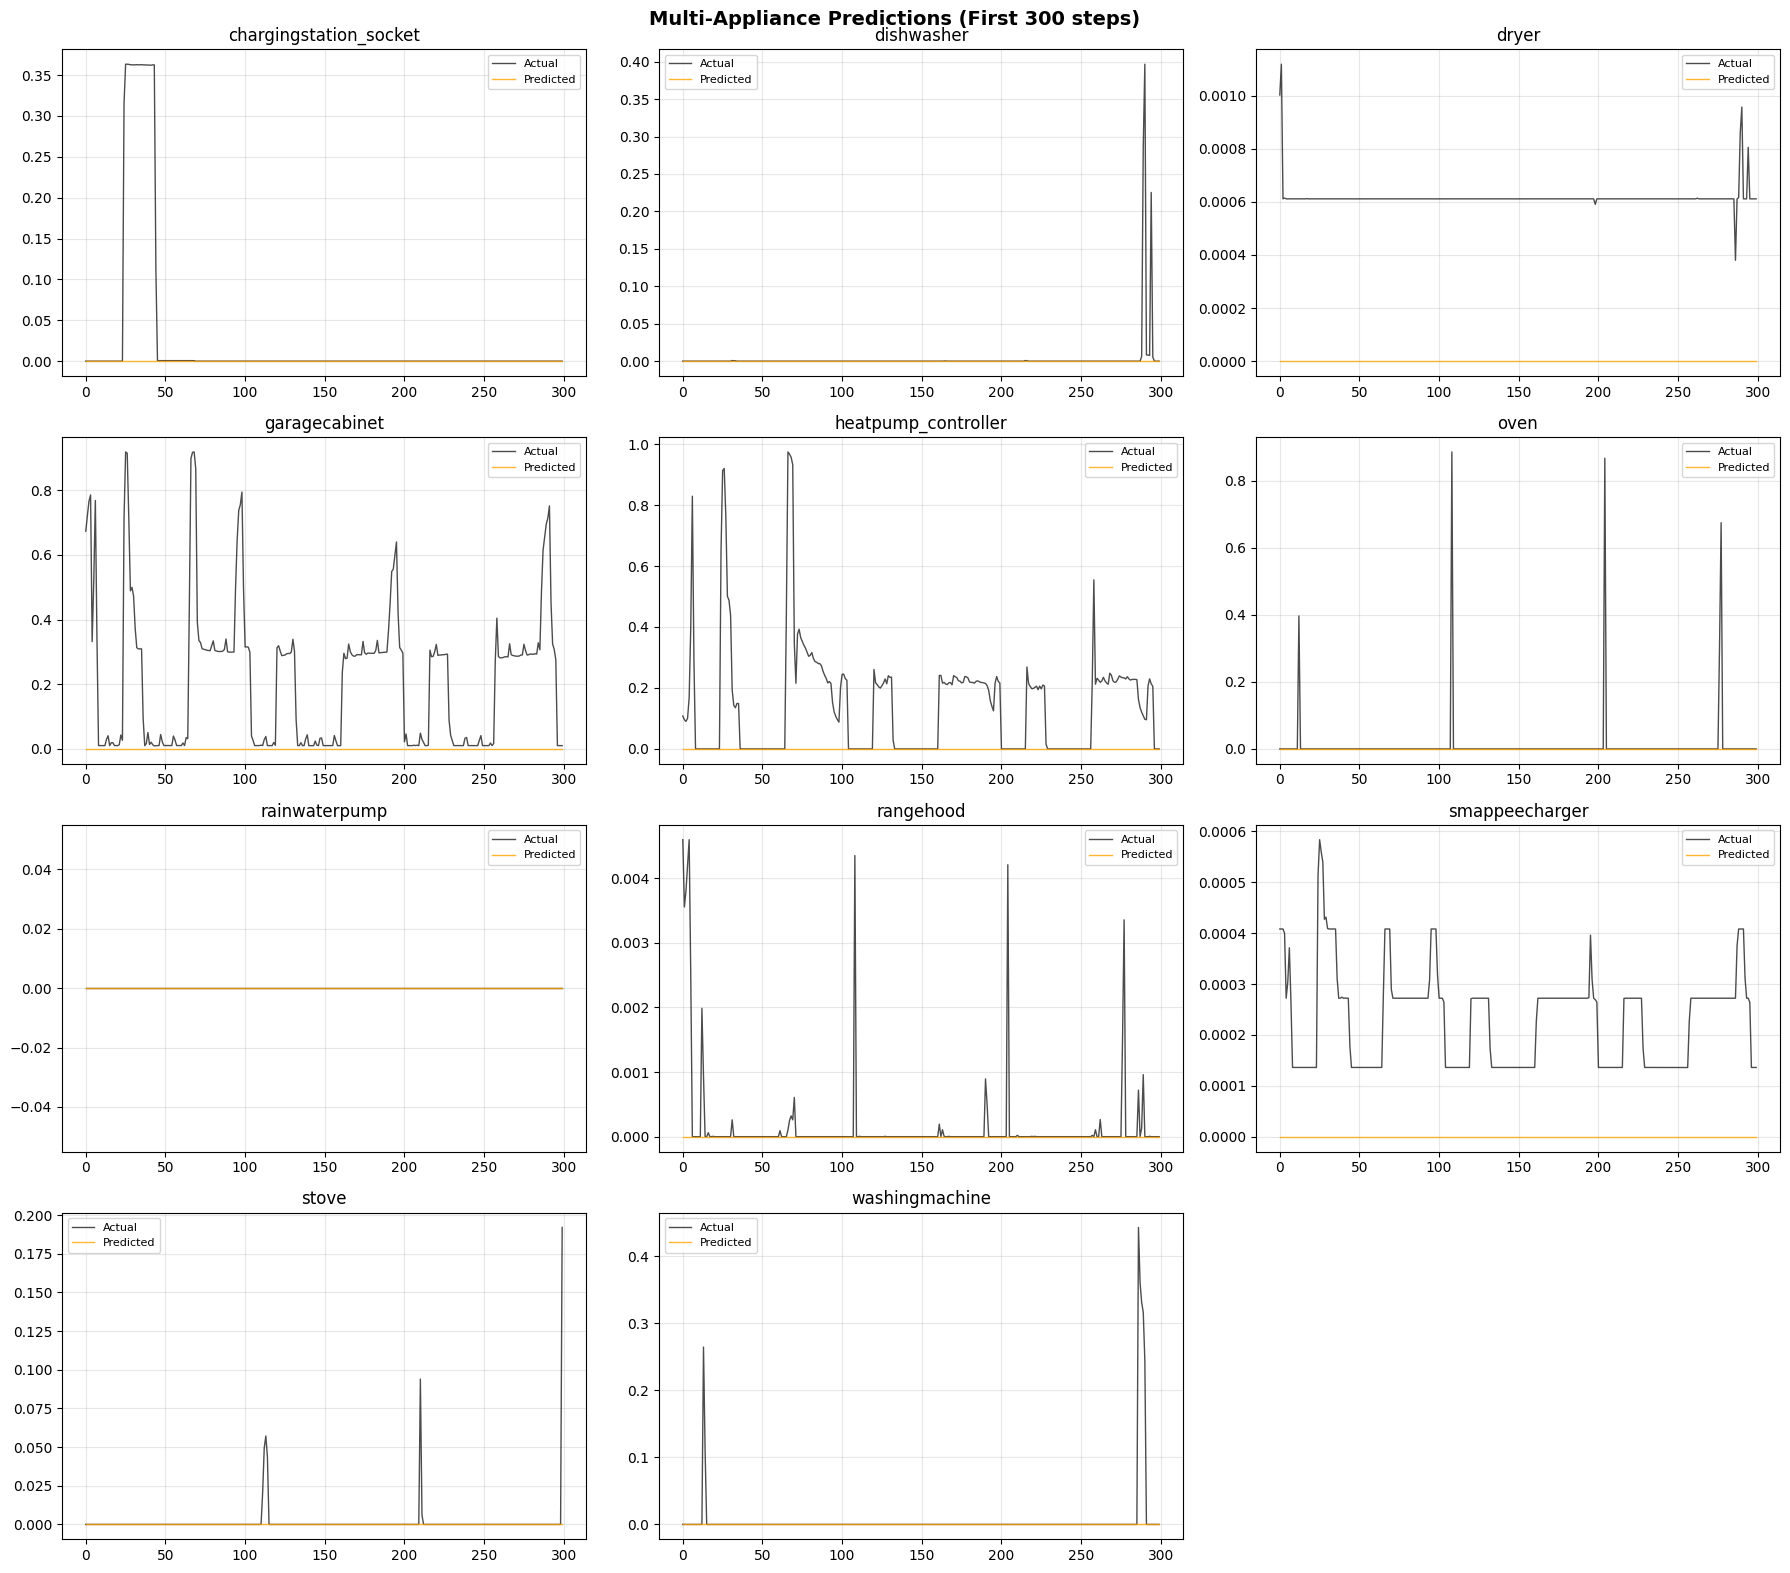

In [35]:
# Grid view for all appliances
n_cols = 3
n_rows = (NUM_APPLIANCES + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for i, appliance in enumerate(APPLIANCES):
    ax = axes[i]
    ax.plot(all_true[:300, i], label='Actual', color='black', alpha=0.7, linewidth=1)
    ax.plot(all_preds[:300, i], label='Predicted', color='orange', alpha=0.8, linewidth=1)
    ax.set_title(f'{appliance}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for j in range(NUM_APPLIANCES, len(axes)):
    axes[j].axis('off')

plt.suptitle('Multi-Appliance Predictions (First 300 steps)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()